_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>
Google Gemini, Open AI 4o , Google Gemini Diffiusion - Planning, Coding, and Verification.</span>

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

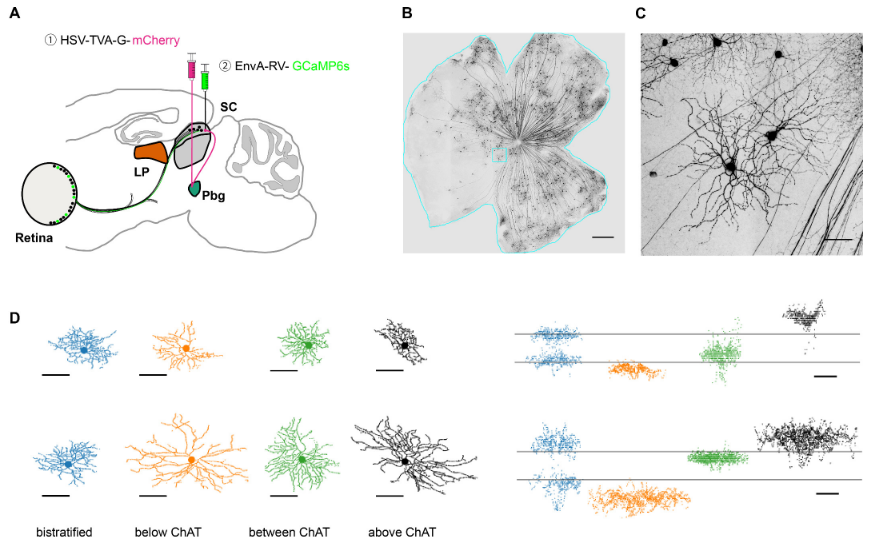

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [1]:
import pandas as pd
import numpy as np
import os

from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

Last updated: 2025-06-22 16:47:09CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

sklearnv: not installed

matplotlib: 3.8.0
pandas    : 2.2.3
seaborn   : 0.13.0
morphopy  : 0.7.2
numpy     : 1.26.2

Watermark: 2.5.0



# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [2]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [3]:
# import swc file
PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [4]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

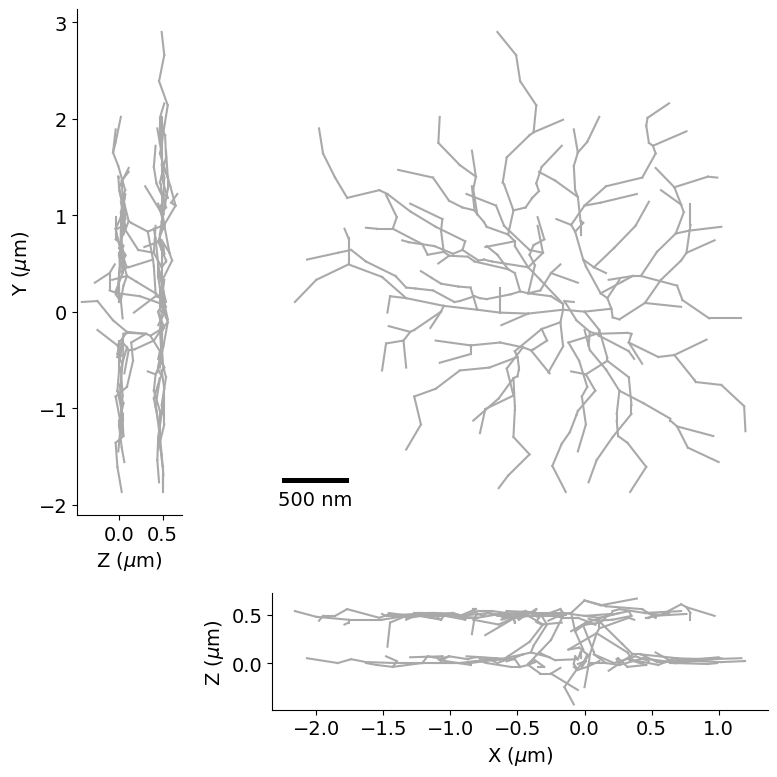

In [5]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------

from morphopy.computation import file_manager as fm
from morphopy.neurontree.plotting import show_threeview

# build full path to example SWC
example_file = "0060_00556_3R_C02_01.swc"
example_path = os.path.join(data_path, example_file)

# load with pca_rot=False and soma_center=False
nt = fm.load_swc_file(example_path, soma_center=False, pca_rot=False)

# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------

# plot XY, XZ, YZ views
fig = plt.figure(figsize=(8, 8))
show_threeview(nt, fig)
fig.tight_layout()
plt.show()

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:** This retinal ganglion cell is bistratified, meaning its dendrites form two distinct, thin arborization bands within the inner plexiform layer (IPL). In the X–Z and Y–Z views you can clearly see two separate lamina of dendritic processes—one in the outer half of the IPL and one in the inner half—rather than a single continuous arbor. Such a “twin‐layer” morphology is characteristic of ON–OFF (or direction‐selective) ganglion cells, which sample inputs in two strata to drive responses at both light onset and offset.

The technical term for this dual-layered appearance is bi-stratified.

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [6]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    swc_files = sorted(glob.glob(os.path.join(path, "*.swc")))
    neurons = []
    for swc in swc_files:
        nt = fm.load_swc_file(swc, soma_center=False, pca_rot=False)
        neurons.append(nt)
    return neurons


neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [7]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics


# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------
ms_list = [compute_morphometric_statistics(nt).iloc[0] for nt in neurons]

# stack into an array of shape (n_cells, 28)
ms_matrix = np.vstack(ms_list)
# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr`` as index (0.5 pts)
# -----------------------------------------------------------------------------------
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))
cell_ids = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]

morphometric_statistics = pd.DataFrame(ms_list, index=cell_ids)
morphometric_statistics.index.name = "Cell_nr"

# preview the first few rows
morphometric_statistics.head()

,branch_points,width,depth,height,tips,stems,total_length,avg_thickness,max_thickness,total_surface,...,median_intermediate_segment_pl,median_terminal_segment_pl,log_max_tortuosity,log_min_tortuosity,log_median_tortuosity,max_branch_angle,min_branch_angle,mean_branch_angle,max_degree,tree_asymmetry
Cell_nr,,,,,,,,,,,,,,,,,,,,,
0002_00535_4L_C01_01,66.0,4.12,5.96,0.54,69.0,3.0,65.793587,1.0,1.0,413.393297,...,0.334798,0.456196,0.253612,0.0,0.005766,124.974479,7.286952,50.402105,3.0,0.726199
0003_00535_1L_C02_01,18.0,3.07,2.66,0.68,23.0,1.0,18.657365,1.0,1.0,117.227681,...,0.345014,0.349991,0.285133,0.0,0.000564,110.367090,18.036960,57.088068,3.0,0.738502
0004_00535_1R_C01_01,54.0,5.05,3.53,0.72,61.0,6.0,41.349847,1.0,1.0,259.808753,...,0.202111,0.281069,0.312270,0.0,0.000000,131.508679,25.596621,59.646776,3.0,0.706943
0006_00535_4L_C02_01,36.0,3.45,4.38,0.49,39.0,4.0,32.249580,1.0,1.0,202.630089,...,0.217084,0.412995,0.251400,0.0,0.017747,130.034126,16.436535,54.683803,2.0,0.601296
0007_00535_4L_C03_01,31.0,4.13,3.86,0.58,40.0,7.0,34.647295,1.0,1.0,217.695372,...,0.248395,0.530086,0.217363,0.0,0.024678,104.036243,2.970445,55.498150,3.0,0.579942


Now let's visualize the data.

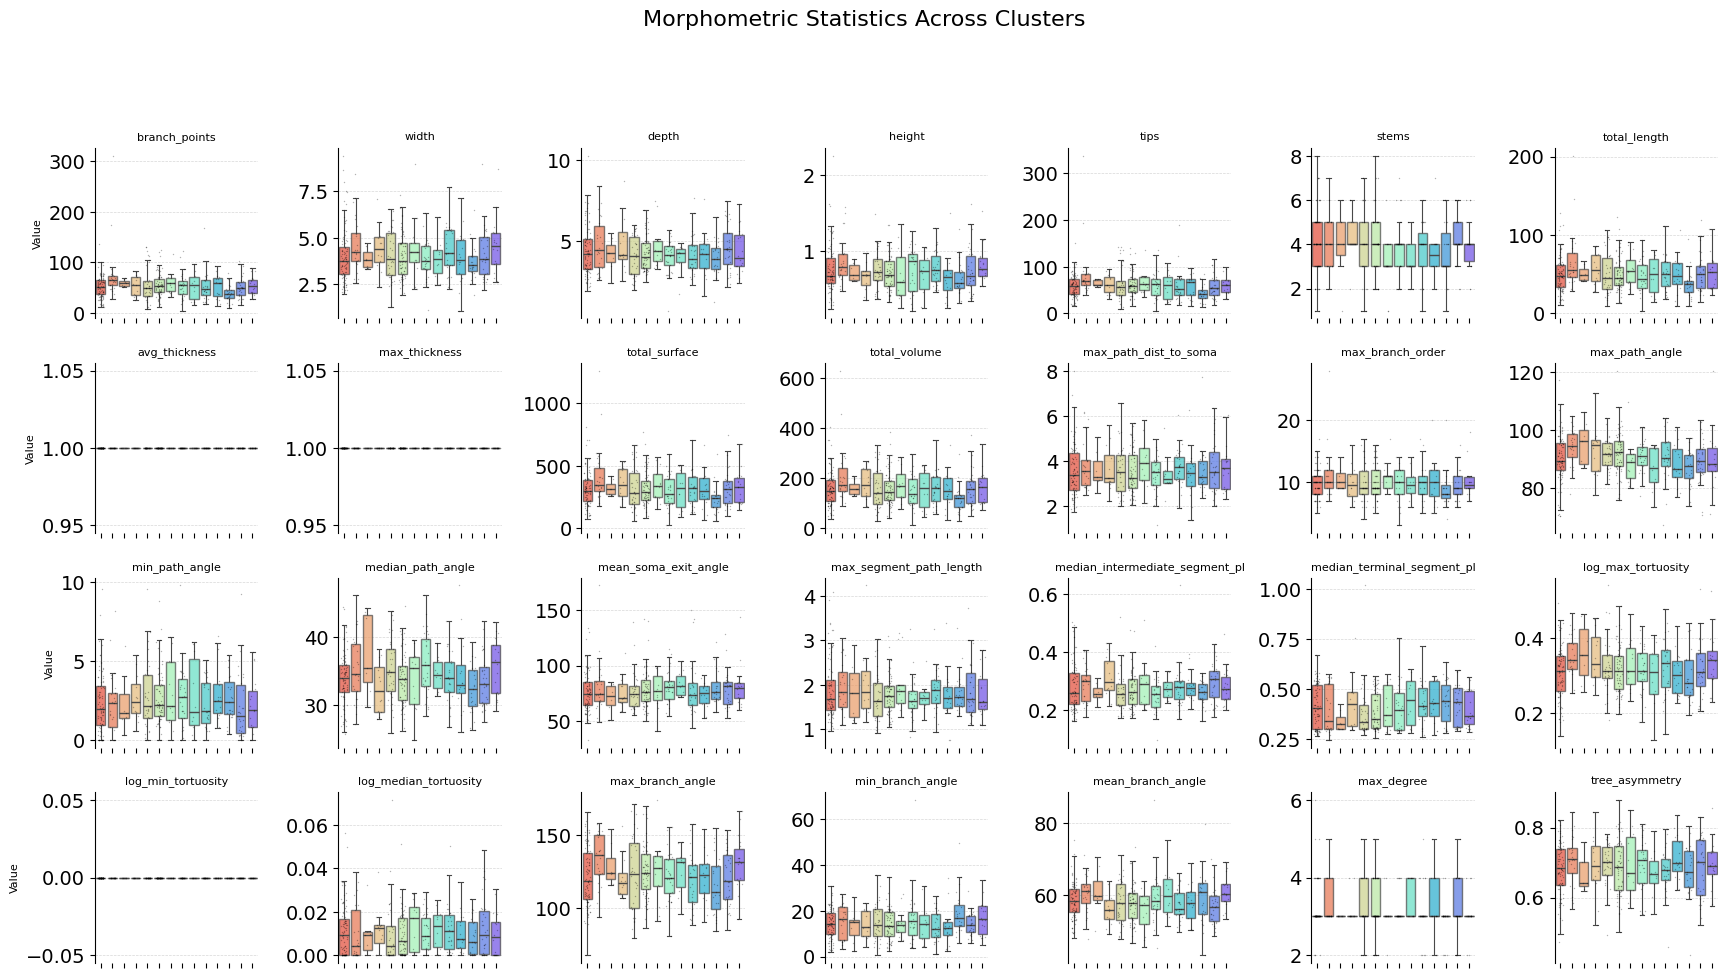

In [8]:
# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------


# Prepare the stats DataFrame with cluster labels
df_stats = morphometric_statistics.reset_index().rename(columns={"index": "Cell_nr"})
df_stats["cluster"] = (
    df_stats["Cell_nr"]
    .str[:4]  # extract "0006" → int 6
    .astype(int)
    .map(labels["cluster"])
)
df_stats = df_stats.dropna(subset=["cluster"])

# Melt to long format for faceting
features = morphometric_statistics.columns.tolist()
df_long = df_stats.melt(
    id_vars=["Cell_nr", "cluster"],
    value_vars=features,
    var_name="feature",
    value_name="value",
)

# Build the FacetGrid
n_cols = 7
g = sns.FacetGrid(
    df_long, col="feature", col_wrap=n_cols, sharey=False, height=2.5, aspect=1
)

# Draw boxplots (without fliers) and overlay stripplots
g.map_dataframe(
    sns.boxplot,
    x="cluster",
    y="value",
    palette=colors,
    fliersize=0,
    boxprops={"alpha": 0.7, "linewidth": 1},
    whiskerprops={"linewidth": 0.8},
    capprops={"linewidth": 0.8},
)
g.map_dataframe(
    sns.stripplot, x="cluster", y="value", color="k", size=1, jitter=0.25, alpha=0.3
)

# Tidy up each axis
axes = g.axes.flatten() if hasattr(g.axes, "flatten") else g.axes
for idx, ax in enumerate(axes):
    # Rotate and shrink x-tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6)
    # Only leftmost column gets a y-label
    if (idx % n_cols) == 0:
        ax.set_ylabel("Value", fontsize=8)
    else:
        ax.set_ylabel("")
    # Remove x-axis label (we rely on tick labels)
    ax.set_xlabel("")
    # Light horizontal gridlines
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    sns.despine(ax=ax, left=False, bottom=True)

# 6) Titles and layout
g.set_titles("{col_name}", size=8)
g.fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)
g.fig.suptitle("Morphometric Statistics Across Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [9]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_statistics - morphometric_statistics.mean()
) / morphometric_statistics.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

feature_names_morpho = morphometric_statistics.columns.tolist()
y = labels["cluster"].values
y_encoded = LabelEncoder().fit_transform(y)

# Calculate ANOVA F-test scores.
# f_classif returns F-statistics and p-values. We only need the F-stats.
f_scores, p_values = f_classif(morphometric_data, y_encoded)

# Calculate Mutual Information scores
mi_scores = mutual_info_classif(morphometric_data, y_encoded, random_state=17)

# Create a new DataFrame to store the results
informativeness_df = pd.DataFrame(
    {
        "Feature": feature_names_morpho,
        "ANOVA_F_Statistic": f_scores,
        "Mutual_Information": mi_scores,
    }
)

# Sort the DataFrame by the F-statistic in descending order
# to see the most informative features at the top.
informativeness_df = informativeness_df.sort_values(
    by="ANOVA_F_Statistic", ascending=False
).reset_index(drop=True)


# Display the final table
print("Feature Informativeness Table")
print("-----------------------------")
print(informativeness_df)

Feature Informativeness Table
-----------------------------
                           Feature  ANOVA_F_Statistic  Mutual_Information
0                            width          22.453216            0.254398
1                           height          19.792955            0.218863
2                            depth          18.332633            0.215260
3                     total_length          16.222915            0.243604
4                    total_surface          16.222915            0.243604
5                     total_volume          16.222915            0.243604
6            max_path_dist_to_soma          15.360768            0.197396
7                mean_branch_angle          13.763381            0.124881
8                median_path_angle          12.680239            0.092306
9          max_segment_path_length          10.190192            0.152162
10              log_max_tortuosity          10.023280            0.177667
11  median_intermediate_segment_pl           9.47256

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

**Answer:**

- **Good separators**  
  - **Branching complexity**: `branch_points`, `tips`, `stems`  
  - **Size metrics**: `total_length`, `total_surface`, `total_volume`  
  - **Branch‐angle statistics**: `max_path_angle`, `median_path_angle`, `mean_branch_angle`  

- **Uninformative features (drop these 5)**
  1. `avg_thickness`  
  2. `max_thickness`  
  3. `log_min_tortuosity`  
  4. `max_degree`  
  5. `min_path_angle` (near‐complete overlap across clusters)

Computing the ANOVA_F_Statistic and mutual information, we find that these features are some of the least informative.

2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

**Answer:**

- **Pros**  
  - **Interpretable**: each feature (e.g. “total_length”, “branch_points”) has a clear biological meaning.  
  - **Fixed-length vector**: yields a compact 28-dimensional representation, ready for PCA, clustering, or classification.  
  - **Fast to compute**: hand-crafted metrics run in milliseconds, even on large datasets.  

- **Cons**  
  - **Lossy compression**: collapsing a full 3D arbor into a few scalars can miss laminar patterns or local motifs.  
  - **Limited vocabulary**: you only capture pre-defined features, so novel or subtle shape differences may be overlooked.  
  - **Scale mismatch**: metrics range from sub-micron angles to hundreds of microns in length, requiring careful normalization or grouping for joint analysis.  

## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [10]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_data - morphometric_data.mean()
) / morphometric_data.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

In [11]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them  for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------

# get list of all SWC files (same order as `neurons`)
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))

# accumulate all xyz‐coordinates
coords = []
for fn in swc_files:
    df = load_swc(fn)
    coords.append(df[["x", "y", "z"]].values)
coords = np.vstack(coords)

# compute global minima/maxima
r_min_x, r_min_y, r_min_z = coords.min(axis=0)
r_max_x, r_max_y, r_max_z = coords.max(axis=0)

print(f"x: {r_min_x:.2f} → {r_max_x:.2f}")
print(f"y: {r_min_y:.2f} → {r_max_y:.2f}")
print(f"z: {r_min_z:.2f} → {r_max_z:.2f}")

x: -6.34 → 5.14
y: -5.49 → 5.36
z: -1.50 → 1.86


In [12]:
from morphopy.computation.feature_presentation import compute_density_maps


# ---------------------------------------------------------------------------------
# complete the config dict and compute the z-density maps for each neuron (1 pts)
# ---------------------------------------------------------------------------------
config_global = dict(
    distance=1.0,  # μm resampling
    n_bins_x=20,
    n_bins_y=20,
    n_bins_z=20,
    density=True,  # return normalized density
    smooth=True,  # apply Gaussian smoothing
    sigma=1.0,  # smoothing σ
    r_min_x=r_min_x,
    r_min_y=r_min_y,
    r_min_z=r_min_z,
    r_max_x=r_max_x,
    r_max_y=r_max_y,
    r_max_z=r_max_z,
)

# Compute density map dict for each neuron
density_maps = [
    compute_density_maps(neurontree=neuron, config_params=config_global)
    for neuron in neurons
]


# extract the z density map
dm_z = np.array([density_map["z_proj"]["data"] for density_map in density_maps])
dm_z.shape

(550, 20)

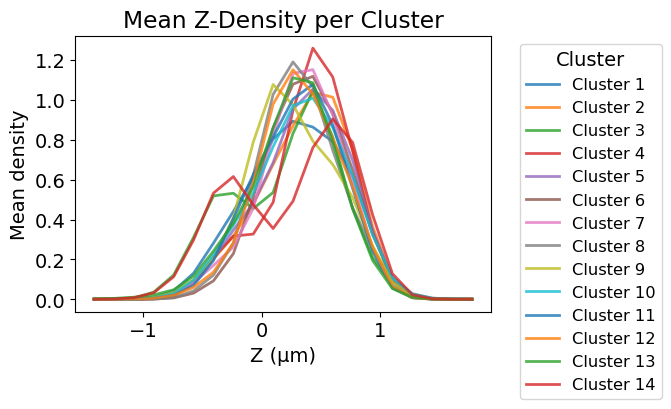

In [13]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# --------------------------------------------------------------------

# Build DataFrame of z-densities
swc_basenames = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]
z_edges = np.linspace(r_min_z, r_max_z, config_global["n_bins_z"] + 1)
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

df_z = pd.DataFrame(dm_z, index=swc_basenames, columns=z_centers)

# Attach cluster labels
df_z["cell_int"] = df_z.index.str[:4].astype(int)
df_z["cluster"] = df_z["cell_int"].map(labels["cluster"])
df_z = df_z.sort_values("cluster").drop(columns="cell_int")

# Plot mean z-density per cluster
plt.figure(figsize=(7, 4))

# get sorted list of clusters (excluding NaN)
cluster_ids = sorted(df_z["cluster"].dropna().unique())

for cl in cluster_ids:
    mean_curve = df_z[df_z["cluster"] == cl].drop(columns="cluster").mean(axis=0)
    plt.plot(
        z_centers,
        mean_curve,
        label=f"Cluster {int(cl)}",
        linewidth=2,
        alpha=0.8,
    )

plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
)
plt.xlabel("Z (µm)")
plt.ylabel("Mean density")
plt.title("Mean Z-Density per Cluster")
plt.tight_layout()
plt.show()

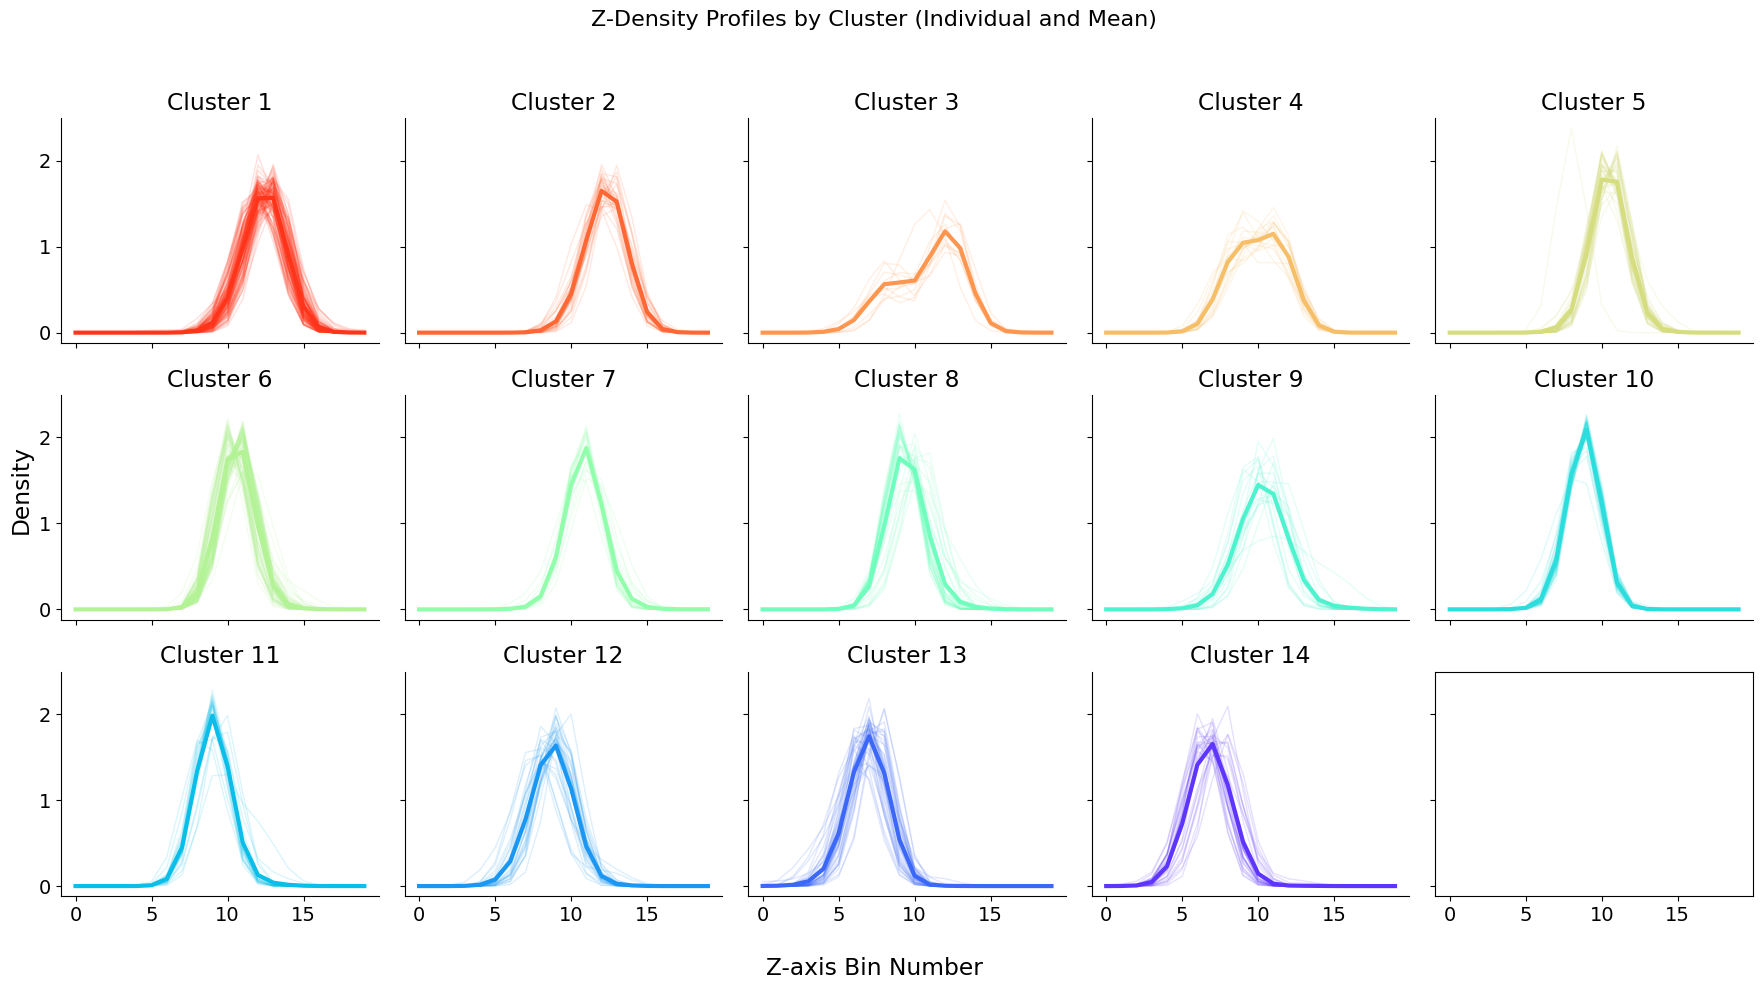

In [14]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# -------------------------------------------------------------------
def plot_density_maps_corrected(dm_z: list, labels: pd.Series, colors: list) -> None:
    """
    Plots the z-density maps for all neurons and their means, sorted by class label.
    Args:
        dm_z (list): List of density map dictionaries.
        labels (pd.Series): Series containing cluster labels.
        colors (list): List of colors for each cluster.
    """
    density_data_list = [item["data"] for item in dm_z]
    df = pd.DataFrame(density_data_list)
    df["cluster"] = labels.values

    # Get the unique, sorted cluster labels to iterate through
    unique_clusters = sorted(df["cluster"].unique())

    # Create a grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(18, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    # Loop through each cluster and its corresponding subplot axis
    for i, cluster_id in enumerate(unique_clusters):
        if i >= len(axes) or i >= len(colors):
            break

        ax = axes[i]
        cluster_maps = df[df["cluster"] == cluster_id].drop("cluster", axis=1)
        # Plot all individual density maps for the cluster
        for row_idx in range(len(cluster_maps)):
            ax.plot(
                cluster_maps.iloc[row_idx].values,
                color=colors[i],
                alpha=0.15,
                linewidth=1,
            )

        # Calculate and plot the mean density map
        mean_density = cluster_maps.mean()
        ax.plot(mean_density.values, color=colors[i], alpha=1.0, linewidth=3)

        ax.set_title(f"Cluster {int(cluster_id)}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # Add overall labels and title
    fig.supxlabel("Z-axis Bin Number")
    fig.supylabel("Density")
    fig.suptitle("Z-Density Profiles by Cluster (Individual and Mean)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Create a list of density maps by looping through each neuron
# and calling the function on each one. This is the main fix.
density_maps = [
    compute_density_maps(neurontree=neuron, config_params=config_global)
    for neuron in neurons
]

# Extract the z-density map from each dictionary in the list using the correct key ("z")
dm_z = [density_map["z_proj"] for density_map in density_maps]
plot_density_maps_corrected(dm_z, labels["cluster"], colors)

### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:**

The Z-density map reveals the characteristic stratification pattern for each cell type. It shows where, along the depth of the retina (the Z-axis), each type of neuron prefers to grow its dendrites. This is a critical feature for defining cell types, as it determines which other cells they can connect with.

You can describe three main patterns you see in the plots:

* **Sharply Monostratified**: Some clusters have a single, very narrow, and sharp peak. This means their dendrites are confined to a very thin layer in the retina. Examples: Clusters 5, 6, 7, 10, and 11.
* **Broadly Monostratified**: Some clusters have a single peak, but it is much wider. Their dendrites are still in one layer, but it's a thicker, more diffuse layer. Examples: Clusters 1, 2, 3, 4, 8, and 9.
* **Bistratified**: Some clusters clearly have two distinct peaks. This means the neurons have two separate layers of dendritic branches at two different depths. Examples: Clusters 12, 13, and 14.


2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:**
As the Task-1 neuron is bi-stratified we would expect it to be one of 12, 13, or 14. 


## Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [15]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------

density_data_list = [item["data"] for item in dm_z]

tsne_morpho = TSNE(
    perplexity=100,
    n_iter=1000,
    metric="euclidean",
    initialization="random",
    random_state=17,
)
embedding_morpho = tsne_morpho.fit(morphometric_data)
# Fit t-SNE with density maps
tsne_density = TSNE(
    perplexity=100,
    n_iter=1000,
    metric="euclidean",
    initialization="random",
    random_state=17,
)
embedding_density = tsne_density.fit(np.array(density_data_list))

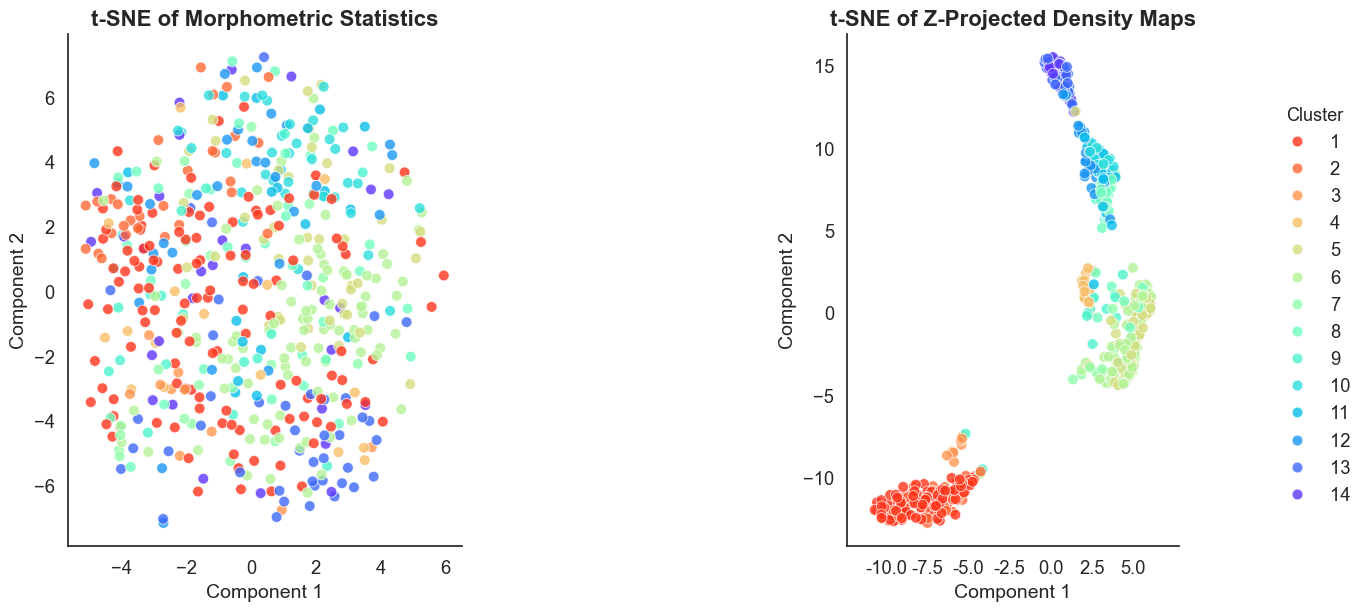

In [30]:
# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------

from matplotlib.ticker import FormatStrFormatter

# —— Global style ——
sns.set(
    style="white",
    font_scale=1.2,
    rc={
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "legend.title_fontsize": 13,
    },
)

# —— Figure + Axes with equal widths ——
fig, axes = plt.subplots(
    1,
    2,
    figsize=(14, 6),
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.15},
    constrained_layout=True,
)

# —— Scatterplots ——
for ax, embedding, subtitle in zip(
    axes,
    [embedding_morpho, embedding_density],
    ["Morphometric Statistics", "Z-Projected Density Maps"],
):
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels["cluster"],
        palette=colors,
        ax=ax,
        s=60,
        alpha=0.8,
        edgecolor="w",
        linewidth=0.6,
    )
    ax.set_title(f"t-SNE of {subtitle}", weight="bold")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_aspect("equal", "box")
    sns.despine(ax=ax)  # remove top/right spines
    ax.grid(False)  # no grid

# —— Shared, sorted legend on the right ——
handles, lbls = axes[1].get_legend_handles_labels()
lbls = list(map(int, lbls))
order = np.argsort(lbls)
fig.legend(
    [handles[i] for i in order],
    [str(lbls[i]) for i in order],
    title="Cluster",
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)
axes[0].legend_.remove()
axes[1].legend_.remove()

# —— Right panel: padding + exact ticks ——
xd = embedding_density[:, 0]
pad = (xd.max() - xd.min()) * 0.10
axes[1].set_xlim(xd.min() - pad, xd.max() + pad)

ticks = np.arange(-10.0, 5.01, 2.5)
axes[1].set_xticks(ticks)
axes[1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.show()

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:** 

The Z-Projected Density Maps produce a much better clustering. In the t-SNE plot for density maps, the different colored clusters are more distinct and well-separated compared to the plot for morphometric statistics, where the clusters are more intermingled. This is likely because the Z-density map explicitly captures the neuron's stratification pattern (i.e., how its dendrites are layered), which is a key biological feature for defining these cell types. Morphometric statistics, in contrast, are global summaries that lose this critical spatial information.

2) What are the advantages of morphometric statistics over density maps 

**Answer:**
- **Interpretability:** each metric (e.g. `branch_points`, `total_length`) has a clear biological meaning.  
- **Compactness:** yields a fixed-length, low-dimensional vector (e.g. 28 features), ready for standard ML workflows.  
- **Speed & simplicity:** very fast to compute and easy to normalize, without having to tune smoothing or binning parameters.  
- **Data efficiency:** works well even with small sample sizes—no need to learn from high-dimensional histograms.

3) What are the advantages of density maps over morphometric statistics 

**Answer:**
- **Rich spatial detail:** preserve the full 1D (or 2D) distribution of the arbor, including multilayer stratification and local motifs.  
- **Fewer hyperparameters in feature engineering:** once you choose bin counts and smoothing, you capture all geometry without hand-selecting tens of metrics.  
- **Compatibility with modern models:** can be fed into convolutional or graph‐based neural networks to learn features directly from the density grid.  
- **Better separability:** as we saw, cells with distinct laminar profiles naturally cluster apart, improving downstream classification or clustering.  

## Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------
def fit_logistic_regression(X: np.ndarray, y: pd.Series) -> float:
    """Fits a logistic regression model and returns the average accuracy.

    Args:
        X (np.ndarray): Feature matrix.
        y (pd.Series): Target labels.

    Returns:
        float: Average accuracy of the model.
    """
    model = LogisticRegressionCV(
        cv=5,
        max_iter=1000,
        class_weight="balanced",
        random_state=17,
        scoring="balanced_accuracy",
    )

    scores = cross_val_score(model, X, y, cv=5, scoring="balanced_accuracy")

    # --- 4. Get the Coefficients (The Right Way) ---
    # To get a single set of coefficients for interpretation, fit the model on all the data
    model.fit(X, y)
    final_coefficients = model.coef_[0]

    return np.mean(scores), final_coefficients


le = LabelEncoder()
_encoded_projection_site = le.fit_transform(labels["projection_site"])

morpho_cv_score, morpho_coefficients = fit_logistic_regression(
    morphometric_data, _encoded_projection_site
)
print(f"Avg. Cross-Validated Balanced Accuracy (Morpho Stats): {morpho_cv_score:.4f}")

density_cv_score, density_coefficients = fit_logistic_regression(
    density_data_list, _encoded_projection_site
)
print(f"Avg. Cross-Validated Balanced Accuracy (Density Maps): {density_cv_score:.4f}")

Avg. Cross-Validated Balanced Accuracy (Morpho Stats): 0.7103
Avg. Cross-Validated Balanced Accuracy (Density Maps): 0.6445


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

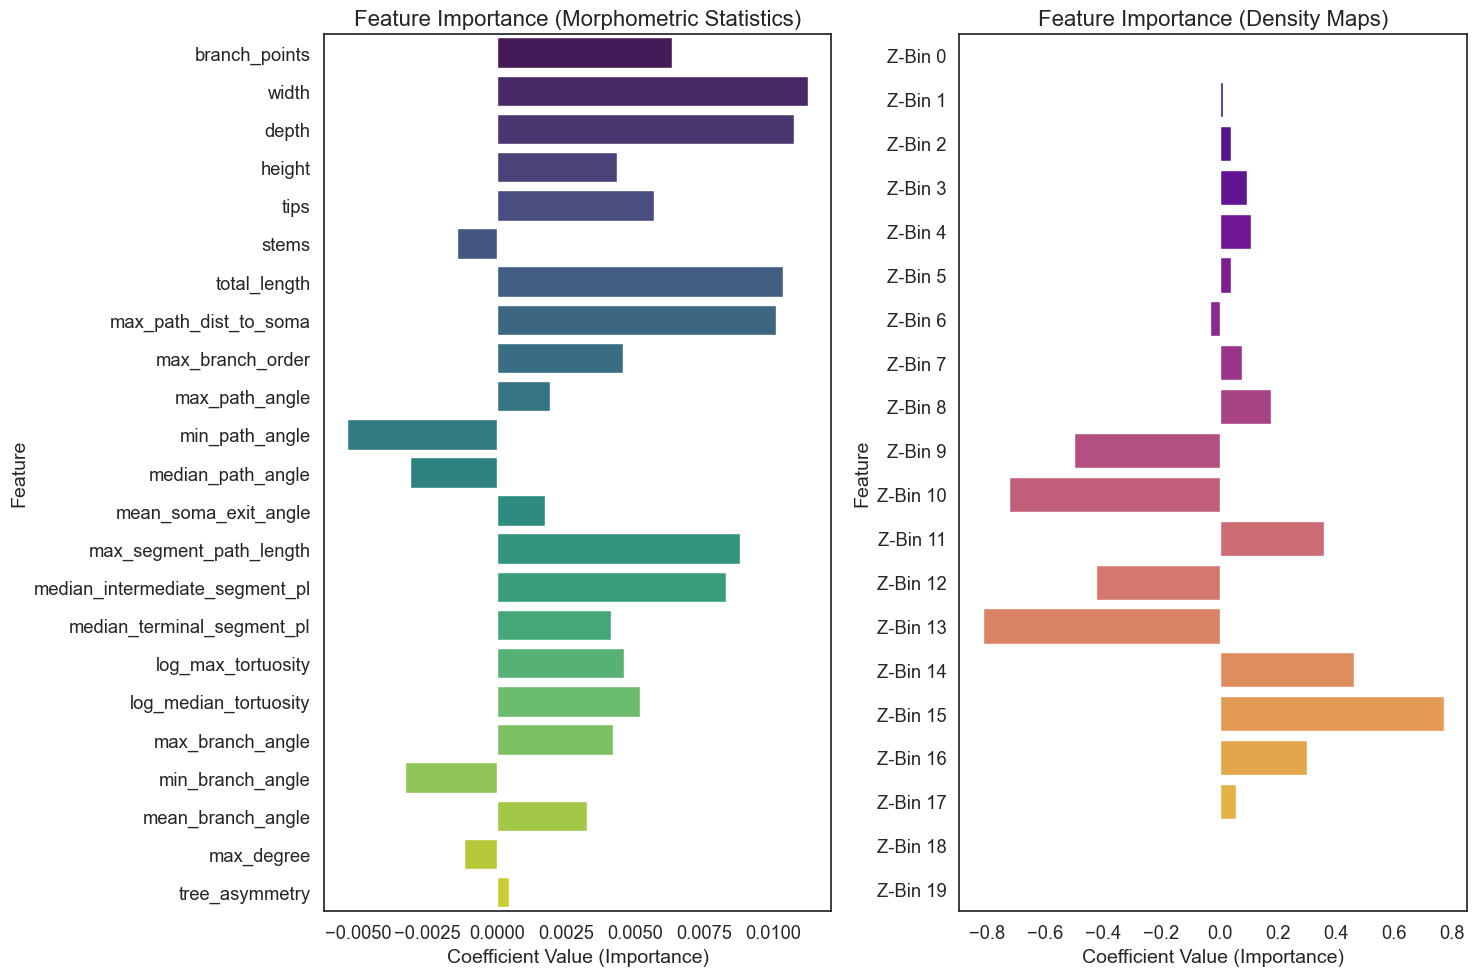

In [32]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------

# Get the corresponding feature names for the plot
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
feature_names_morpho = morphometric_statistics.drop(
    features_to_drop, axis=1
).columns.tolist()
X_density = np.array([item["data"] for item in dm_z])
feature_names_density = [f"Z-Bin {i}" for i in range(X_density.shape[1])]

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.barplot(
    x=morpho_coefficients, y=feature_names_morpho, ax=axes[0], palette="viridis"
)
axes[0].set_title("Feature Importance (Morphometric Statistics)")
axes[0].set_xlabel("Coefficient Value (Importance)")
axes[0].set_ylabel("Feature")

# Plot coefficients for density maps
plt.subplot(1, 2, 2)
sns.barplot(
    x=density_coefficients, y=feature_names_density, ax=axes[1], palette="plasma"
)
axes[1].set_title("Feature Importance (Density Maps)")
axes[1].set_xlabel("Coefficient Value (Importance)")
axes[1].set_ylabel("Feature")


plt.tight_layout()
plt.show()

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:**

Based on the plot of the fitted logistic regression coefficients, the most informative morphometric for predicting the projection site is *total_length*, which has the largest positive coefficient. This suggests that neurons with a 
greater total dendritic length are significantly more likely to project to one of the sites.

Other important features include *width* and *depth* (also with positive coefficients) and tips (with a strong negative coefficient). Features such as *max_degree* and *median_intermediate_segment_pl* also contribute to the prediction.

Conversely, many statistics like *index* and *stems* have coefficients near zero, indicating they are not very informative for this particular classification task.

Looking at Density maps we find that Z-Bin 13-15 as well as some early bins like Z-Bin 2-5  and Z-bin 10 are informative for cluster decision.


## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)